In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM, Bidirectional, ConvLSTM2D, Conv1D, MaxPool1D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

2023-03-07 19:11:17.895574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 19:11:18.036006: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 19:11:18.041405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 19:11:18.041419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
data = pd.read_csv('data/processed/body_combined.csv')
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-0.593280,-0.295724,-0.674764,-749.046297,599.261452,1044.343394
1,Falling,-0.578631,-0.299387,-0.672933,-747.215186,592.669454,1044.465468
2,Falling,-0.573138,-0.297555,-0.663778,-745.628223,586.443678,1044.343394
3,Falling,-0.567644,-0.293893,-0.661031,-744.285409,578.753014,1044.465468
4,Falling,-0.554827,-0.299387,-0.657369,-743.064669,571.306497,1044.831690


In [3]:
data.shape

(191004, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191004 entries, 0 to 191003
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   191004 non-null  object 
 1   x_acc   191004 non-null  float64
 2   y_acc   191004 non-null  float64
 3   z_acc   191004 non-null  float64
 4   x_gyr   191004 non-null  float64
 5   y_gyr   191004 non-null  float64
 6   z_gyr   191004 non-null  float64
dtypes: float64(6), object(1)
memory usage: 10.2+ MB


In [5]:
# check for null data
data.isnull().sum()

label    0
x_acc    0
y_acc    0
z_acc    0
x_gyr    0
y_gyr    0
z_gyr    0
dtype: int64

In [6]:
# count the datapoints of different activity
data['label'].value_counts()

Walking    91674
Stairs     44352
Running    29964
Sitting    15774
Falling     9240
Name: label, dtype: int64

### Balance this data 

In [7]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')
#data['mag_acc'] = data['mag_acc'].astype('float')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191004 entries, 0 to 191003
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   191004 non-null  object 
 1   x_acc   191004 non-null  float64
 2   y_acc   191004 non-null  float64
 3   z_acc   191004 non-null  float64
 4   x_gyr   191004 non-null  float64
 5   y_gyr   191004 non-null  float64
 6   z_gyr   191004 non-null  float64
dtypes: float64(6), object(1)
memory usage: 10.2+ MB


In [9]:
# frame size, Frames per second
Fs = 33

In [10]:
activities = data['label'].value_counts().index

In [11]:
activities

Index(['Walking', 'Stairs', 'Running', 'Sitting', 'Falling'], dtype='object')

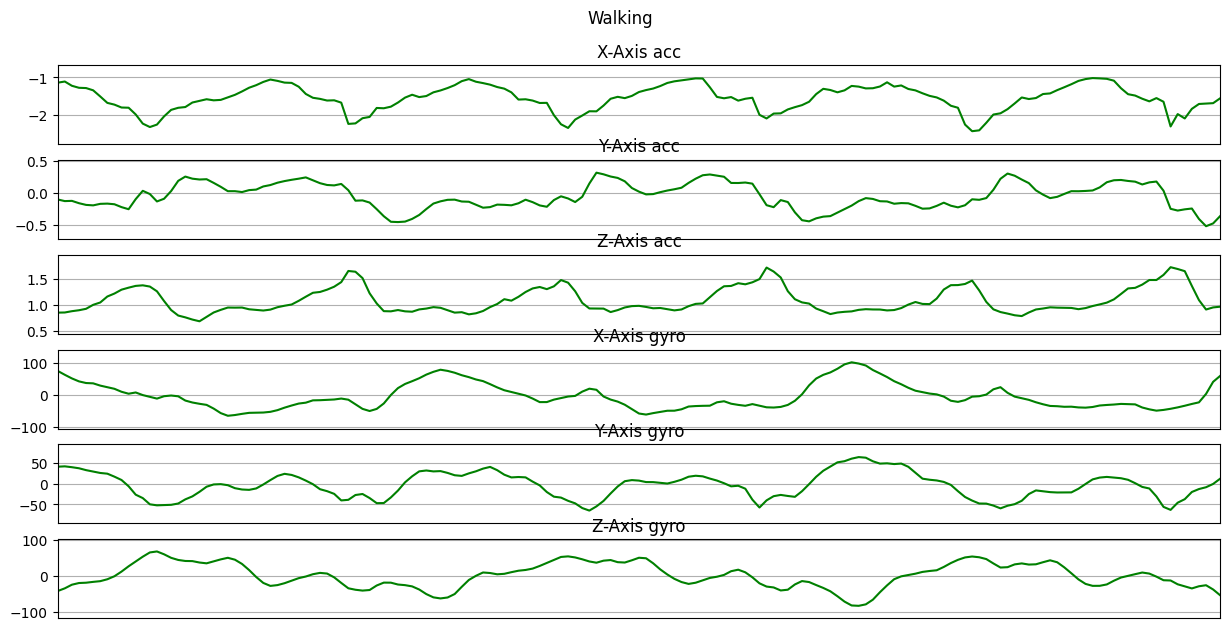

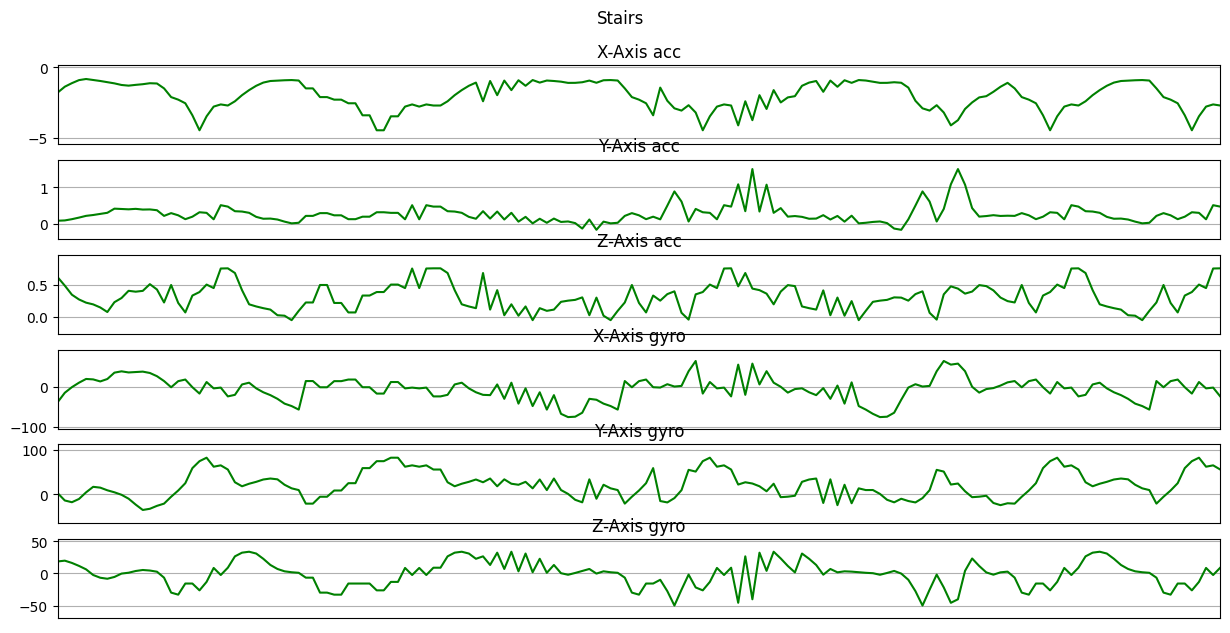

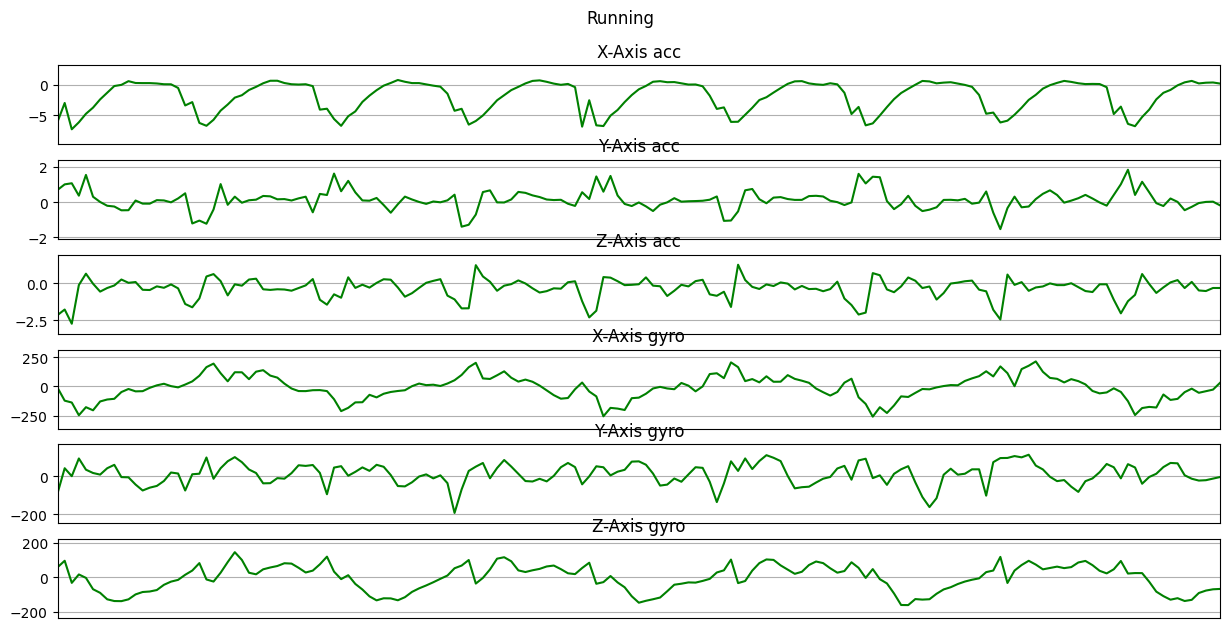

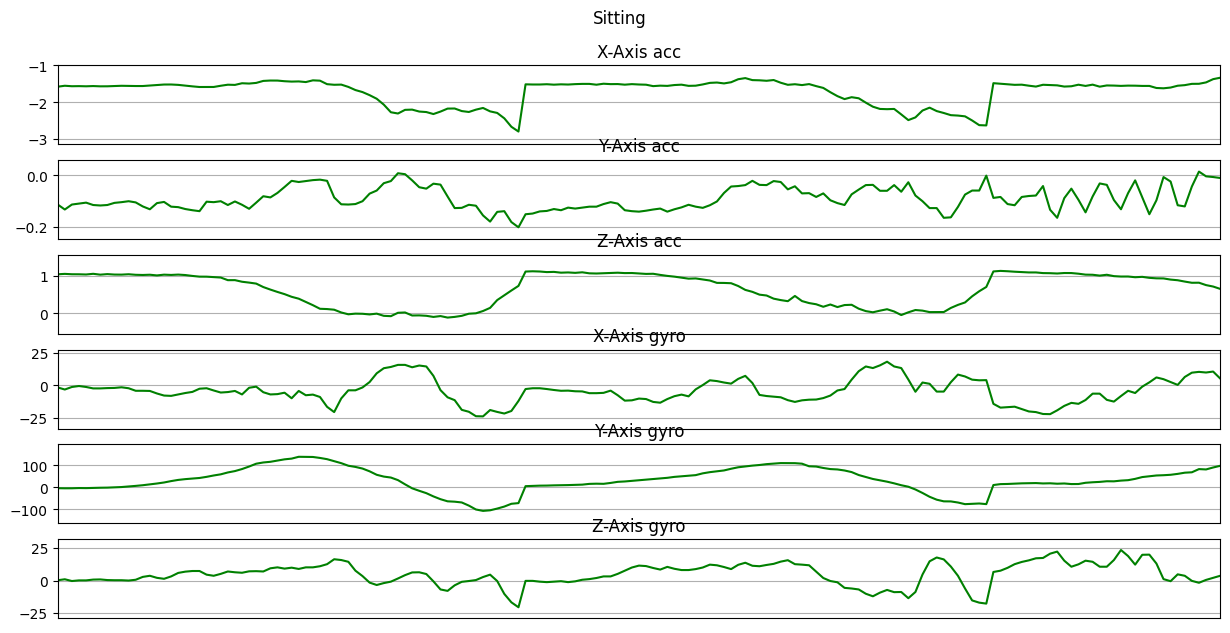

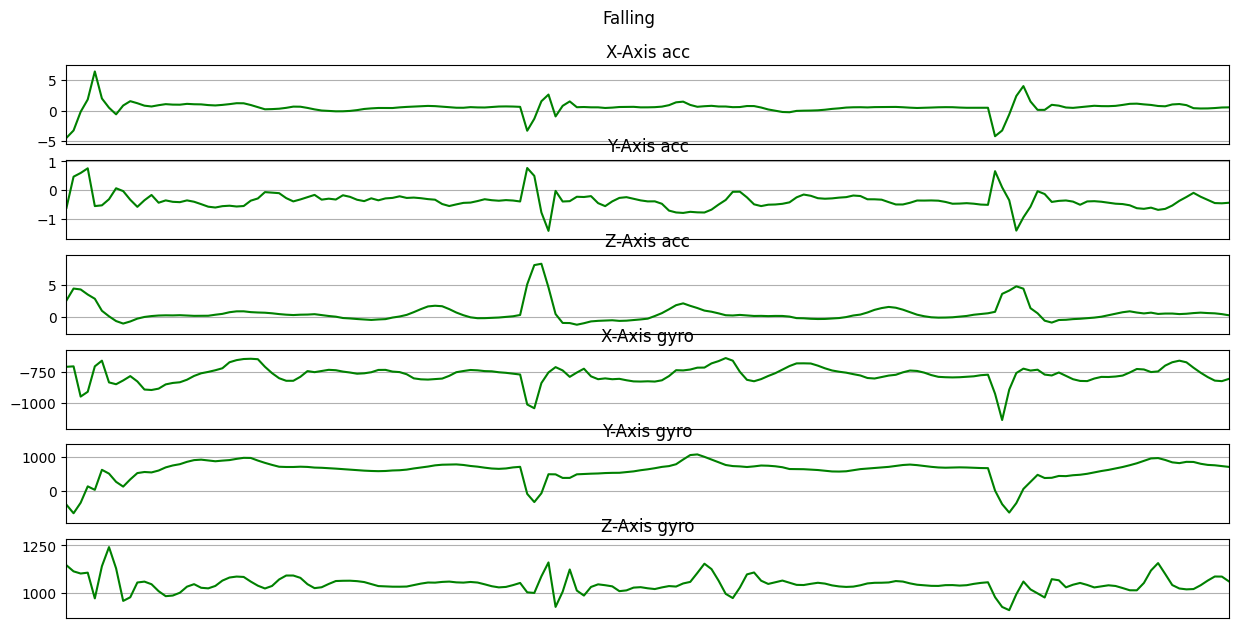

In [12]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(15, 7), sharex=True)
    x_ticks = np.arange(len(data))
    plot_axis(ax0, x_ticks, data['x_acc'], 'X-Axis acc')
    plot_axis(ax1, x_ticks, data['y_acc'], 'Y-Axis acc')
    plot_axis(ax2, x_ticks, data['z_acc'], 'Z-Axis acc')
    plot_axis(ax3, x_ticks, data['x_gyr'], 'X-Axis gyro')
    plot_axis(ax4, x_ticks, data['y_gyr'], 'Y-Axis gyro')
    plot_axis(ax5, x_ticks, data['z_gyr'], 'Z-Axis gyro')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['label'] == activity)][Fs*5:Fs*10]
    plot_activity(activity, data_for_plot)

In [13]:
counts = data['label'].value_counts()
counts

Walking    91674
Stairs     44352
Running    29964
Sitting    15774
Falling     9240
Name: label, dtype: int64

In [14]:
# calculate weights to balance weights on imbalance classes
# references: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# references: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
n_classes = 5
n_total = data.shape[0]

weight_0 = n_total / (n_classes * counts[0]) # 
weight_1 = n_total / (n_classes * counts[1]) #
weight_2 = n_total / (n_classes * counts[2])
weight_3 = n_total / (n_classes * counts[3])
weight_4 = n_total / (n_classes * counts[4])
class_weight = {0: weight_0, 1: weight_1, 2:weight_2, 3: weight_3, 4: weight_4}

In [15]:
class_weight

{0: 0.416702663786897,
 1: 0.8613095238095239,
 2: 1.2748898678414098,
 3: 2.4217573221757323,
 4: 4.134285714285714}

In [16]:
data.shape

(191004, 7)

In [17]:
data['label'].value_counts()

Walking    91674
Stairs     44352
Running    29964
Sitting    15774
Falling     9240
Name: label, dtype: int64

In [18]:
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-0.593280,-0.295724,-0.674764,-749.046297,599.261452,1044.343394
1,Falling,-0.578631,-0.299387,-0.672933,-747.215186,592.669454,1044.465468
2,Falling,-0.573138,-0.297555,-0.663778,-745.628223,586.443678,1044.343394
3,Falling,-0.567644,-0.293893,-0.661031,-744.285409,578.753014,1044.465468
4,Falling,-0.554827,-0.299387,-0.657369,-743.064669,571.306497,1044.831690


In [19]:
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
data.tail()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
190999,Walking,-1.460311,-0.070498,0.931120,36.500137,7.568590,-7.324442,4
191000,Walking,-1.416364,-0.109867,0.866115,35.157323,18.311106,0.732444,4
191001,Walking,-1.424604,-0.180364,0.869778,33.814509,26.612140,0.976592,4
191002,Walking,-1.463973,-0.236213,0.888089,28.931547,33.814509,-2.929777,4
191003,Walking,-1.519822,-0.267342,0.882595,28.443251,36.866359,-10.620441,4


In [20]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [21]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']]
y = data['label_id']

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,label_id
0,1.090977,-0.696242,-1.595668,-1.958188,1.652865,2.043967,0
1,1.109405,-0.708374,-1.593219,-1.952304,1.629190,2.044261,0
2,1.116316,-0.702308,-1.580974,-1.947204,1.606830,2.043967,0
3,1.123226,-0.690177,-1.577301,-1.942889,1.579209,2.044261,0
4,1.139351,-0.708374,-1.572403,-1.938966,1.552464,2.045142,0
...,...,...,...,...,...,...,...
190999,0.000258,0.049831,0.552099,0.566183,-0.472217,-0.487024,4
191000,0.055543,-0.080580,0.465160,0.561868,-0.433635,-0.467634,4
191001,0.045177,-0.314107,0.470058,0.557553,-0.403822,-0.467046,4
191002,-0.004349,-0.499109,0.494548,0.541861,-0.377954,-0.476448,4


### Frame Preparation 

In [24]:
import scipy.stats as stats

In [25]:
Fs = 33
frame_size = Fs*2
hop_size = 66

In [26]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        # mag_acc = df['mag_acc'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size])[0][0]
        frames.append([x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
        #frames.append([x_acc, y_acc, z_acc])
        #frames.append([x_gyr, y_gyr, z_gyr])
        #frames.append([mag_acc])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [27]:
X, y = get_frames(scaled_X, frame_size, hop_size)

/tmp/ipykernel_128930/3635283732.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label_id'][i: i + frame_size])[0][0]


In [28]:
X.shape, y.shape

((2893, 66, 6), (2893,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7, stratify = y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 7, stratify = y_train)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2314, 66, 6)
(2314,)
(579, 66, 6)
(579,)


In [34]:
X_train.shape, X_test.shape

((2314, 66, 6), (579, 66, 6))

### 2D CNN Model 

In [33]:
X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2], 1)

model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

### ConvLSTM2D

In [40]:
X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2],1,1)
X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2],1,1)
X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2],1,1)

#def build_convlstm2d():
model = Sequential()
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=X_train[0].shape,
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

### LSTM

In [36]:
X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

model = Sequential()
model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

2023-03-07 19:12:37.365762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 19:12:37.365887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-07 19:12:37.365969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-07 19:12:37.369077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-07 19:12:37.369172: W tensorflow/stream_executor/platform/default/dso_loader

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 66, 256)           269312    
                                                                 
 dropout (Dropout)           (None, 66, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 66, 256)           525312    
                                                                 
 flatten (Flatten)           (None, 16896)             0         
                                                                 
 dense (Dense)               (None, 64)                1081408   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

### Bi-LSTM

In [94]:
X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

model = Sequential()
model.add(Bidirectional(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

### CNN-LSTM

In [49]:
X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))
model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 65, 256)           3328      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 256)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32, 256)           525312    
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               819300    
                                                      

In [50]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [51]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs = 20, validation_data= (X_val, y_val), verbose=1, callbacks = [es])

# # convert the history.history dict to a pandas DataFrame:     
# history_df = pd.DataFrame(history.history) 

# # save history to csv: 
# hist_csv_file = 'history/cnnlstm_body.csv'
# with open(hist_csv_file, mode='w') as f:
#     history_df.to_csv(f)

#     # count the number of epochs after early stopping
# number_of_epochs = len(history.history['loss'])

Epoch 1/20
73/73 [==============================] - 8s 82ms/step - loss: 1.0133 - accuracy: 0.6383 - val_loss: 0.6695 - val_accuracy: 0.7689
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.5771 - accuracy: 0.7969 - val_loss: 0.5491 - val_accuracy: 0.8229
Epoch 3/20
73/73 [==============================] - 5s 75ms/step - loss: 0.4504 - accuracy: 0.8302 - val_loss: 0.4092 - val_accuracy: 0.8510
Epoch 4/20
73/73 [==============================] - 5s 75ms/step - loss: 0.3876 - accuracy: 0.8621 - val_loss: 0.4408 - val_accuracy: 0.8467
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.3593 - accuracy: 0.8721 - val_loss: 0.3626 - val_accuracy: 0.8855
Epoch 6/20
73/73 [==============================] - 5s 75ms/step - loss: 0.3474 - accuracy: 0.8708 - val_loss: 0.3238 - val_accuracy: 0.8920
Epoch 7/20
73/73 [==============================] - 5s 74ms/step - loss: 0.3119 - accuracy: 0.8881 - val_loss: 0.2977 - val_accuracy: 0.8834
Epoch 8/20
73

In [105]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

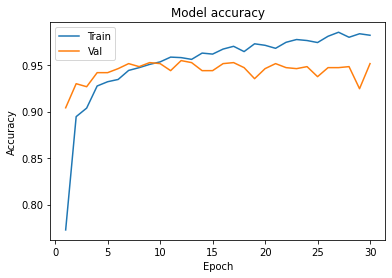

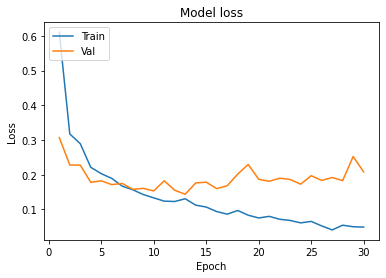

In [106]:
plot_learningCurve(history, number_of_epochs)

### Confusion Matrix 

In [52]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

19/19 [==============================] - 1s 27ms/step


0.9326424870466321

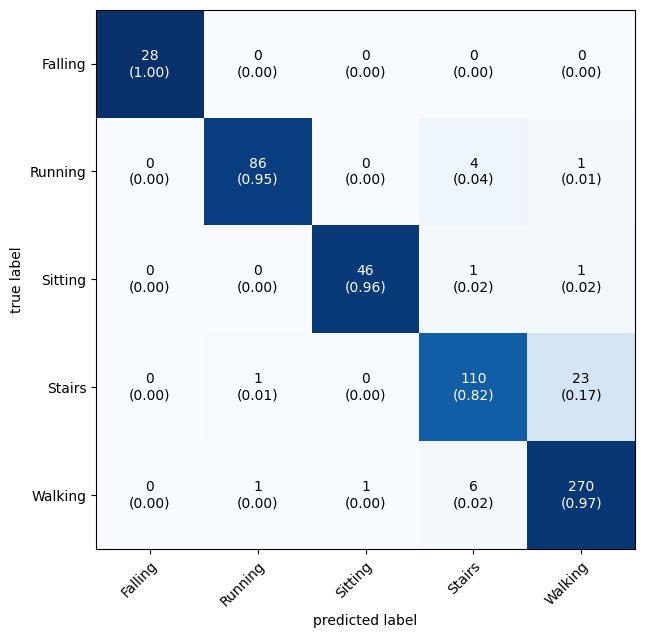

In [53]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [54]:
model.save('models/new/lstm_6_young_body.h5')

In [55]:
y_predqq = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, y_predqq)

19/19 [==============================] - 1s 33ms/step


0.9326424870466321

In [60]:
# load elderly chest model, test on young chest test set
model_pretrained = load_model('models/new/lstm_6_elderly_body.h5')

In [63]:
y_pred = np.argmax(model_pretrained.predict(X_test), axis=-1)

19/19 [==============================] - 2s 60ms/step


0.4697754749568221

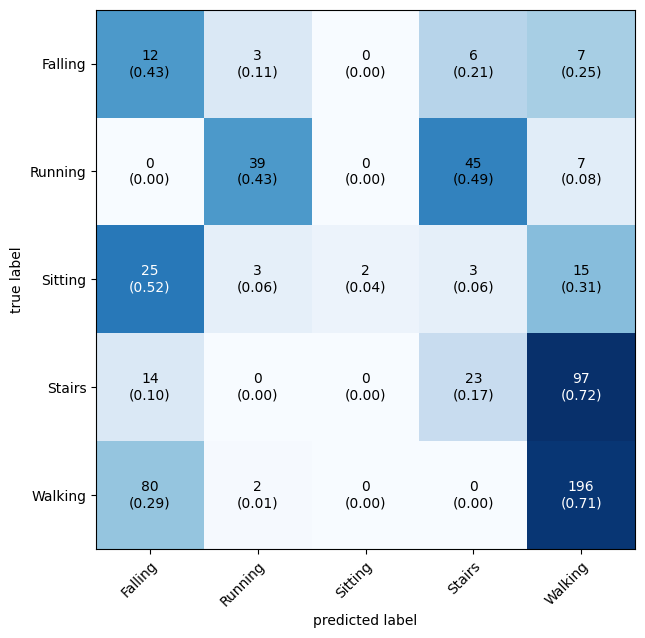

In [64]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)